# Applied Machine Learning: Credit Card Approval Prediction

*By Daniel Deutsch and José Lucas Barretto*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
# Matplotlib styles
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# random state
random_state=42

## Data Processing

At this staage the goal is to read both datasets and adapt its content for our classification models.

### Processing raw data

#### Credit records

In [3]:
# Reads the dataset
df_credit_record = pd.read_csv("./datasets/credit_record.csv")

# Renames columns
df_credit_record.rename(columns=str.lower, inplace=True)

# Numericalize status
df_credit_record.replace({'status': {'X': 0, 'C': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6}}, inplace=True)

# Calculates the metric
df_credit_record = df_credit_record.groupby('id')['status'].mean().reset_index()

# Sets the label
df_credit_record['is_good'] = 1*(df_credit_record['status'] <= 1)

#### Application Records

In [4]:
# Reads the dataset
df_application_record = pd.read_csv("./datasets/application_record.csv")

# Renames columns
df_application_record.rename(columns=str.lower, inplace=True)

# numericalyze and rename education level
df_application_record.replace({
    'name_education_type': {
        'Higher education': 4,
        'Academic degree': 4,
        'Incomplete higher': 3,
        'Secondary / secondary special': 2,
        'Lower secondary': 1, 
    }
}, inplace=True)
df_application_record.rename(columns={'name_education_type': 'education_level'}, inplace=True)

# transform days employed into is_unemployed
df_application_record['is_unemployed'] = 1*(df_application_record['days_employed'] > 0)

# drop uninteresting columns - birthday, days employed
df_application_record.drop(columns=['days_employed', 'days_birth'], inplace=True)

#### Merging data

In [5]:
df = pd.merge(df_credit_record, df_application_record, how='inner', on='id')

del df_credit_record, df_application_record

### Train-test split

In [7]:
# define categorical, numerical, and other interesting vars
categorical = [
    'code_gender', 
    'flag_own_car', 
    'flag_own_realty', 
    'name_income_type',
    'name_family_status', 
    'name_housing_type', 
    'flag_mobil', 
    'flag_work_phone',
    'flag_phone', 
    'flag_email',
    'occupation_type'
]

numerical = [
    'cnt_children',
    'amt_income_total',
    'cnt_fam_members'
]

other = [
    'is_unemployed',
    'education_level'
]

# define X and y datasets
X = df[categorical + numerical + other]
y = df['is_good']

# split between train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

### Processing features

In [8]:
# initialize encoder for categorical vars
enc = OneHotEncoder(drop='first', sparse=False)

# fit transform encoder to train data
X_train_categorical = pd.DataFrame(enc.fit_transform(X_train[categorical]), index=X_train.index, columns=enc.get_feature_names_out())

# transform encoder to test data
X_test_categorical = pd.DataFrame(enc.transform(X_test[categorical]), index=X_test.index, columns=enc.get_feature_names_out())

In [9]:
# initialize scaler for numerical vars
scaler = StandardScaler()

# fit transform scaler to train data
X_train_numerical = pd.DataFrame(scaler.fit_transform(X_train[numerical]), index=X_train.index, columns=numerical)

# transform scaler to test data
X_test_numerical = pd.DataFrame(scaler.transform(X_test[numerical]), index=X_test.index, columns=numerical)

In [10]:
# concatenate numerical and categorical vars
X_train_normal = pd.concat((X_train_numerical, X_train_categorical, X_train[other]), axis=1)
X_test_normal = pd.concat((X_test_numerical, X_test_categorical, X_test[other]), axis=1)

## Modeling, Feature Selection, Explainability

### Random Forest

#### Training and Evaluating the Model

In [12]:
clf = RandomForestClassifier()

param_grid = {
    "n_estimators":[250, 300, 500],
    "max_depth":[500, 1000, 2000],
    "max_features":[5,10,20,X_train_normal.shape[1]]
}

clf = RandomForestClassifier()

clf_tuned = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=3,
)

clf_tuned.fit(X_train_normal, y_train)
clf_tuned.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 2/3] END max_depth=500, max_features=5, n_estimators=250;, score=0.700 total time=   3.8s
[CV 1/3] END max_depth=500, max_features=5, n_estimators=250;, score=0.709 total time=   4.0s
[CV 3/3] END max_depth=500, max_features=5, n_estimators=250;, score=0.703 total time=   4.2s
[CV 1/3] END max_depth=500, max_features=5, n_estimators=300;, score=0.709 total time=   4.7s
[CV 2/3] END max_depth=500, max_features=5, n_estimators=300;, score=0.699 total time=   4.9s
[CV 3/3] END max_depth=500, max_features=5, n_estimators=300;, score=0.709 total time=   5.1s
[CV 2/3] END max_depth=500, max_features=5, n_estimators=500;, score=0.695 total time=   7.6s
[CV 1/3] END max_depth=500, max_features=5, n_estimators=500;, score=0.697 total time=   7.9s
[CV 1/3] END max_depth=500, max_features=10, n_estimators=250;, score=0.704 total time=   5.2s
[CV 2/3] END max_depth=500, max_features=10, n_estimators=250;, score=0.702 total time=   5

RandomForestClassifier(max_depth=1000, max_features=10, n_estimators=500)

In [14]:
pred = clf_tuned.best_estimator_.predict(X_test_normal)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.42      0.14      0.21       406
           1       0.97      0.99      0.98     10532

    accuracy                           0.96     10938
   macro avg       0.69      0.57      0.60     10938
weighted avg       0.95      0.96      0.95     10938



#### Feature Importance

##### Permutation Importance

In [15]:
feature_names = X_train_normal.columns

result = permutation_importance(
    clf_tuned.best_estimator_, X_test_normal, y_test, n_repeats=10, n_jobs=-1, random_state=random_state
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


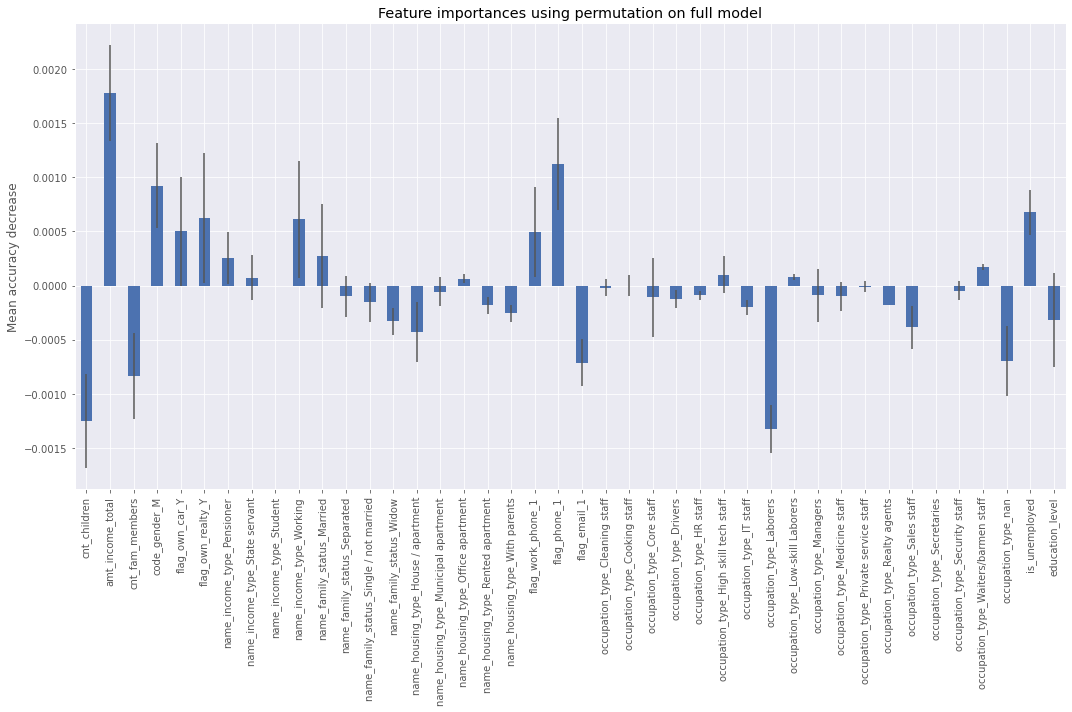

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

##### Synergy and Redundance

In [19]:
# fit the model inspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.inspection import LearnerInspector
inspector = LearnerInspector(n_jobs=-3)
inspector.fit(crossfit=ranker.best_model_crossfit_)

ImportError: cannot import name 'LearnerRanker' from 'facet.selection' (/opt/anaconda3/envs/ml/lib/python3.8/site-packages/facet/selection/__init__.py)

In [ ]:
# visualise synergy as a matrix
from pytools.viz.matrix import MatrixDrawer
synergy_matrix = inspector.feature_synergy_matrix()
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Synergy Matrix")

In [24]:
!pip list

Package                       Version
----------------------------- ---------
appnope                       0.1.3
argon2-cffi                   20.1.0
asttokens                     2.0.5
attrs                         21.4.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.11.1
bleach                        4.1.0
Boruta                        0.3
certifi                       2021.10.8
cffi                          1.15.0
cloudpickle                   2.0.0
colorama                      0.4.4
cycler                        0.11.0
debugpy                       1.5.1
decorator                     5.1.1
defusedxml                    0.7.1
entrypoints                   0.4
executing                     0.8.3
fastjsonschema                2.15.1
fonttools                     4.25.0
gamma-facet                   2.0.dev1
gamma-pytools                 2.0.dev8
importlib-resources           5.2.0
ipykernel                     6.13.0
ipython 